Copyright © 2023 Gurobi Optimization, LLC

# Text Dissimilarity using Linear Programming

In this notebook, we will walk-through a unique example demonstrating how you can apply optimization to assess text dissimilarity. There are numerous potential applications such as in detecting plagiarism, information retrieval, clustering, text categorization, topic detection, question answer session, machine translation and text summarization. Read here for [more](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=1aff7b429f99f529228a4299a5794971adeb1ca3#:~:text=There%20are%20several%20applications%20or,machine%20translation%2C%20text%20summarization%20etc).

The **Word Mover's Distance** (WMD) is a popular measure of text similarity, which measures the semantic distance between two documents. In this notebook, we will achieve two goals:
- Given two text passages, model WMD as an optimization problem and compute it
- Examine a plagiarized passage from a book, then find the original passage in that book that has the closest semantic meaning to the given passage


|<img src="figure_obama.png" width="500" align="center">| 
|:--:|
|An illustration of Word Movers' Distance to measure the similarity between two documents. <b>Image Credits: [Towards AI](https://towardsai.net/p/nlp/word-movers-distance-wmd-explained-an-effective-method-of-document-classification-89cb258401f4) </b>| 

## I. The data



### Google Word-to-Vector Data

In order to find the semantic distance between words, we start by constructing a vector embedding for each word.
For this, we use the popular 'word2vec' dataset from Google News. This dataset has vector embeddings that are pre-trained for 3 million words. Read more about the dataset [here](https://code.google.com/archive/p/word2vec/).

We now import all the packages needed and download the word2vec data. Note that in the code below, downloading the data takes up to a minute. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt   
from gensim.models import KeyedVectors 
from scipy import spatial

import gensim.downloader as api
model = api.load('word2vec-google-news-300')


We have downloaded the massive dataset of word-vector embeddings. For example, the embedding of the word "Sherlock' is given below, in a 300-dimension space.

In [2]:
model['Sherlock']


array([-0.00646973,  0.04882812, -0.10205078,  0.1328125 , -0.01855469,
       -0.10253906, -0.10693359,  0.01556396,  0.22949219,  0.06054688,
       -0.02392578,  0.09912109, -0.04541016, -0.01965332, -0.01202393,
        0.04370117,  0.046875  , -0.16210938, -0.02453613, -0.16894531,
       -0.03662109, -0.21289062,  0.25      , -0.06396484,  0.25195312,
        0.31054688,  0.0145874 ,  0.18945312, -0.02233887,  0.0072937 ,
       -0.328125  , -0.20703125, -0.01586914,  0.09033203, -0.06347656,
       -0.07470703, -0.12255859,  0.23046875, -0.06835938,  0.09179688,
        0.07861328, -0.11669922,  0.078125  ,  0.2734375 ,  0.078125  ,
       -0.03808594, -0.02685547,  0.203125  ,  0.1640625 ,  0.14941406,
       -0.11279297,  0.01977539, -0.19238281,  0.10302734,  0.08642578,
       -0.20214844,  0.06738281, -0.25585938, -0.15527344,  0.05493164,
       -0.00915527,  0.24121094,  0.04638672,  0.02453613, -0.22265625,
       -0.10644531, -0.30273438,  0.01446533, -0.24414062,  0.04

### Enter two documents 

Next, we create the two documents to compare. In this example we look at a sentence from Sir Arthur Conan Doyle’s *The Adventures of Sherlock Holmes* (the original literary data-driven detective): 

"The little man stood glancing from one to the other of us with half-frightened, half-hopeful eyes, as one who is not sure whether he is on the verge of a windfall or of a catastrophe."


We use a popular text generation technology ([ChatGPT](https://chat.openai.com/chat)) to construct semantically similar sentence. 

<img src="chatgpt clip.gif" width="750" align="center">


We store the two sentences (documents) as strings. You can try other pairs of sentences too. Some are given in the commented text below.

In [3]:
document1 = 'The little man stood glancing from one to the other of us with half-frightened, half-hopeful eyes, as one who is not sure whether he is on the verge of a windfall or of a catastrophe.'
document2 = 'The small gentleman stood before us, looking back and forth with eyes that expressed both fear and anticipation, as if unsure whether he was about to experience great fortune or a disastrous turn of events.'

# document1 = 'I barely saw Sherlock recently.'
# document2 = 'Lately, I have had little opportunity to catch a glimpse of Sherlock.'

# document1 = 'Obama speaks to the media in Illinois.'
# document2 = 'The President greets the press in Chicago'

##  II. Pre-processing the text

Before comparing the two documents, we first eliminate certain words that may not carry any semantic value, for example, prepositions (e.g., in, on, under), conjunctions (e.g., and, for, but), and determiners (e.g., a, an, the, another). These words are called **stop words**. Read more [here](https://kavita-ganesan.com/what-are-stop-words/#.ZCCurezMLt0).
We also remove punctuation marks and proper nouns, and then we convert all the words to their lower-case equivalents.

We use the nltk package to ensure this. In the code below, the lines with "nltk.download" need to be executed the first time this notebook is run. You may comment the lines for subsequent runs.

In [4]:
import nltk 
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')  
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import PorterStemmer 
 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rahul.swamy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Split each document into words (or "tags"). Each word is classified into several categories. For example, 'NN' corresponds to a singular noun and 'VBD' is a verb in the past tense. See [here](https://pythonprogramming.net/natural-language-toolkit-nltk-part-speech-tagging/) for the complete list of classifications. 

In [5]:
tagged_doc1 = nltk.tag.pos_tag(document1.split())
tagged_doc2 = nltk.tag.pos_tag(document2.split()) 
print(tagged_doc1)
print(tagged_doc2) 
 

[('The', 'DT'), ('little', 'JJ'), ('man', 'NN'), ('stood', 'VBD'), ('glancing', 'VBG'), ('from', 'IN'), ('one', 'CD'), ('to', 'TO'), ('the', 'DT'), ('other', 'JJ'), ('of', 'IN'), ('us', 'PRP'), ('with', 'IN'), ('half-frightened,', 'JJ'), ('half-hopeful', 'JJ'), ('eyes,', 'NN'), ('as', 'IN'), ('one', 'CD'), ('who', 'WP'), ('is', 'VBZ'), ('not', 'RB'), ('sure', 'JJ'), ('whether', 'IN'), ('he', 'PRP'), ('is', 'VBZ'), ('on', 'IN'), ('the', 'DT'), ('verge', 'NN'), ('of', 'IN'), ('a', 'DT'), ('windfall', 'NN'), ('or', 'CC'), ('of', 'IN'), ('a', 'DT'), ('catastrophe.', 'NN')]
[('The', 'DT'), ('small', 'JJ'), ('gentleman', 'NN'), ('stood', 'VBD'), ('before', 'IN'), ('us,', 'JJ'), ('looking', 'VBG'), ('back', 'RB'), ('and', 'CC'), ('forth', 'NN'), ('with', 'IN'), ('eyes', 'NNS'), ('that', 'WDT'), ('expressed', 'VBD'), ('both', 'DT'), ('fear', 'NN'), ('and', 'CC'), ('anticipation,', 'NN'), ('as', 'IN'), ('if', 'IN'), ('unsure', 'JJ'), ('whether', 'IN'), ('he', 'PRP'), ('was', 'VBD'), ('about', '

Knowing the categories, we first remove the proper nouns, given by the classification NNP (for singular proper nouns) and NNPS (for plural proper nouns).

In [6]:
edited_sentence1 = [word for word,tag in tagged_doc1 if tag not in ['NNP','NNPS']]
edited_sentence2 = [word for word,tag in tagged_doc2 if tag not in ['NNP','NNPS']] 
print(edited_sentence1)
print(edited_sentence2) 
 

['The', 'little', 'man', 'stood', 'glancing', 'from', 'one', 'to', 'the', 'other', 'of', 'us', 'with', 'half-frightened,', 'half-hopeful', 'eyes,', 'as', 'one', 'who', 'is', 'not', 'sure', 'whether', 'he', 'is', 'on', 'the', 'verge', 'of', 'a', 'windfall', 'or', 'of', 'a', 'catastrophe.']
['The', 'small', 'gentleman', 'stood', 'before', 'us,', 'looking', 'back', 'and', 'forth', 'with', 'eyes', 'that', 'expressed', 'both', 'fear', 'and', 'anticipation,', 'as', 'if', 'unsure', 'whether', 'he', 'was', 'about', 'to', 'experience', 'great', 'fortune', 'or', 'a', 'disastrous', 'turn', 'of', 'events.']


Next, we remove all the punctuation marks.

In [7]:
tokenizer = RegexpTokenizer(r'\w+') 
processed_doc1 = tokenizer.tokenize(' '.join(edited_sentence1))
processed_doc2 = tokenizer.tokenize(' '.join(edited_sentence2))
print(processed_doc1)
print(processed_doc2) 

['The', 'little', 'man', 'stood', 'glancing', 'from', 'one', 'to', 'the', 'other', 'of', 'us', 'with', 'half', 'frightened', 'half', 'hopeful', 'eyes', 'as', 'one', 'who', 'is', 'not', 'sure', 'whether', 'he', 'is', 'on', 'the', 'verge', 'of', 'a', 'windfall', 'or', 'of', 'a', 'catastrophe']
['The', 'small', 'gentleman', 'stood', 'before', 'us', 'looking', 'back', 'and', 'forth', 'with', 'eyes', 'that', 'expressed', 'both', 'fear', 'and', 'anticipation', 'as', 'if', 'unsure', 'whether', 'he', 'was', 'about', 'to', 'experience', 'great', 'fortune', 'or', 'a', 'disastrous', 'turn', 'of', 'events']


We now remove all the stop words.

In [8]:
processed_doc1 = [x.lower() for x in processed_doc1]
processed_doc2 = [x.lower() for x in processed_doc2]
processed_doc1 = [i for i in processed_doc1 if i not in stopwords.words('english')]
processed_doc2 = [i for i in processed_doc2 if i not in stopwords.words('english')]

print(processed_doc1,'\n', processed_doc2) 

['little', 'man', 'stood', 'glancing', 'one', 'us', 'half', 'frightened', 'half', 'hopeful', 'eyes', 'one', 'sure', 'whether', 'verge', 'windfall', 'catastrophe'] 
 ['small', 'gentleman', 'stood', 'us', 'looking', 'back', 'forth', 'eyes', 'expressed', 'fear', 'anticipation', 'unsure', 'whether', 'experience', 'great', 'fortune', 'disastrous', 'turn', 'events']


For a better visualization of the processed documents, let us create word clouds out of them.

Document 1:


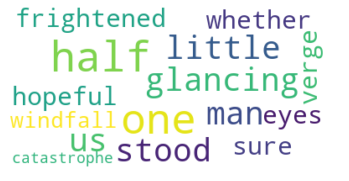

Document 2:


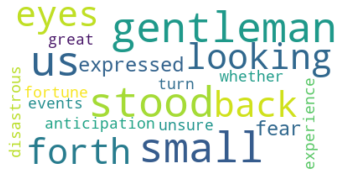

In [9]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

print("Document 1:") 
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(processed_doc1))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("Document 2:")
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(processed_doc2))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

To prepare the documents for the optimization model, let us store the frequency of occurrences of each word.

In [10]:
freqency_D1 = {i: processed_doc1.count(i)/len(processed_doc1) for i in processed_doc1}
freqency_D2 = {i: processed_doc2.count(i)/len(processed_doc2) for i in processed_doc2}

D1 = set(processed_doc1)
D2 = set(processed_doc2) 
print(D1,D2)

{'us', 'one', 'verge', 'frightened', 'little', 'eyes', 'sure', 'hopeful', 'windfall', 'glancing', 'whether', 'catastrophe', 'half', 'man', 'stood'} {'great', 'fear', 'turn', 'unsure', 'gentleman', 'forth', 'events', 'back', 'expressed', 'eyes', 'whether', 'small', 'disastrous', 'fortune', 'us', 'looking', 'anticipation', 'experience', 'stood'}


We now get the word-to-word distance matrix. Given the vector embeddings of two words $\overline{x}_1$ and $\overline{x}_2$, we take the cosine distance between them given by, $\overline{x}_1 . \overline{x}_2$/$|\overline{x}_1||\overline{x}_2|$. Uncomment the code below to see the sorted distances between all pairs of words in the two documents.

In [11]:
import numpy as np
distance = {(i,j): spatial.distance.cosine(model[i],model[j]) for i in D1 for j in D2} 

# dict(sorted(distance.items(), key=lambda item: item[1]))

## III. Computing text dissimilarity using a linear program

Now, we model the Word Mover's Distance (WMD) as an optimization problem.
The idea is to send *flow* from the words in document 1 to the words in document 2 in such a way that the product of the distance and flow is minimized.
In other words, we send higher flow between words that have a smaller distance, and hence, are semantically closer to each other.

In the figure below, we see how the optimal flow corresponds to pairs of words that are semantically the closest.

|<img src="figure_obama2.png" width="500" align="center">| 
|:--:|
|An illustration of Word Movers' Distance to measure the similarity between two documents. <b>Image Credits: [Towards AI](https://towardsai.net/p/nlp/word-movers-distance-wmd-explained-an-effective-method-of-document-classification-89cb258401f4) </b>| 

<!-- The score: weighted sum of distances. -->

In optimization terminology, this model is famously called the **transportation model**, where the flow corresponds to transporting commodities between locations (such as warehouse and retail locations). 


Before we build the model, we first define the input parameters.

### Input Parameters

$D_1, D_2$: two documents each representing a set of words,

$p_w$: frequency of word $w$ in $D_1$,

$q_{w'}$: frequency of word $w'$ in $D_2$,

$d(w,w')$: distance between word embeddings of $w$ and $w'$.

To build the model, we initiate the Gurobi model.

In [12]:
import gurobipy as gp
from gurobipy import GRB

# Initialize Model
m = gp.Model("Text_similarity")

### Flow variables

The following is the key decision variable in the model.

$f_{w,w'}$: Amount of flow from word $w$ in $D_1$ to word $w'$ in $D_2$.



We can add the flow variables for all pairs of words using the addVars function. We allow the flow variable to be between $0$ and $1$, and hence set the lower bound (lb) to $0$ and the upper bound (ub) to $1$.

In [13]:
f = m.addVars(D1,D2,name="f",lb=0,ub=1) 

### Objective: Minimize the net distance times flow 


The higher the flow, the more semantically close those words are expected to be. This is achieved by defining the objective function to be the product of the distance and the flow, mathematically expressed as:

\begin{aligned}
\textrm{minimize} \ \sum_{w \in D_1} \sum_{w' \in D_2}&  d(w,w') f_{w,w'}
\end{aligned}



Minimizing this objective naturally allocates higher flow values to word-pairs that have a smaller distance. We can add this objective to the Gurobi model below.

In [14]:
m.ModelSense = GRB.MINIMIZE
m.setObjective(sum(f[w,w_prime]*distance[w,w_prime] for w in D1 for w_prime in D2))#/sum(cost[w,w_prime] for w in D for w_prime in D_prime))
m.update()

### Constraints


Finally, we define constraints to ensure that each word has a representation in the flow proportional to its frequency of occurrence.
We do this by ensuring: the net flow exiting from each word $w$ in document $D_1$ is equal to its frequency of occurrence in $D_1$.
Similarly, the net flow entering each word $w'$ in document $D_2$ is equal to its frequency of occurrence in $D_2$.
These two constraints can be expressed by the following two equations.

\begin{aligned}
 \sum_{w' \in D_2} f_{w,w'} &= p_w \quad  \forall \ w \in D_1, \\
\ \sum_{w \in D_1} f_{w,w'} &= q_{w'} \quad  \forall  \ w' \in D_2
\end{aligned}

We add these constraints to the Gurobi model below using the addConstrs function.

In [15]:
m.addConstrs(f.sum(w, '*') == freqency_D1[w] for w in D1)
m.addConstrs(f.sum('*', w_prime) == freqency_D2[w_prime] for w_prime in D2)
 

{'great': <gurobi.Constr *Awaiting Model Update*>,
 'fear': <gurobi.Constr *Awaiting Model Update*>,
 'turn': <gurobi.Constr *Awaiting Model Update*>,
 'unsure': <gurobi.Constr *Awaiting Model Update*>,
 'gentleman': <gurobi.Constr *Awaiting Model Update*>,
 'forth': <gurobi.Constr *Awaiting Model Update*>,
 'events': <gurobi.Constr *Awaiting Model Update*>,
 'back': <gurobi.Constr *Awaiting Model Update*>,
 'expressed': <gurobi.Constr *Awaiting Model Update*>,
 'eyes': <gurobi.Constr *Awaiting Model Update*>,
 'whether': <gurobi.Constr *Awaiting Model Update*>,
 'small': <gurobi.Constr *Awaiting Model Update*>,
 'disastrous': <gurobi.Constr *Awaiting Model Update*>,
 'fortune': <gurobi.Constr *Awaiting Model Update*>,
 'us': <gurobi.Constr *Awaiting Model Update*>,
 'looking': <gurobi.Constr *Awaiting Model Update*>,
 'anticipation': <gurobi.Constr *Awaiting Model Update*>,
 'experience': <gurobi.Constr *Awaiting Model Update*>,
 'stood': <gurobi.Constr *Awaiting Model Update*>}

### Solve the model

We have added all the decision variables, objective, and constraints, and we are ready to solve the model!

In [16]:
m.optimize()  

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 34 rows, 285 columns and 570 nonzeros
Model fingerprint: 0xaf3d87f2
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-02, 1e-01]
Presolve time: 0.01s
Presolved: 34 rows, 285 columns, 570 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.2223600e-01   7.925697e-01   0.000000e+00      0s
      24    5.5060376e-01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.02 seconds (0.00 work units)
Optimal objective  5.506037592e-01


The model is solved, and the flow solution is stored in a Pandas dataframe for easy visualization.

How can we interpret the result? How much dissimilarity is good enough to detect plagiarism?

In [17]:
print("Dissimilarity score:",round((m.ObjVal),2),"\n")

solution = pd.DataFrame()
flow = {(i,j): f[i,j].X for i in D1 for j in D2 if f[i,j].X > 0} 
# flow = sorted(flow.items(), key=lambda item: item[1],reverse=True)
solution['word 1'] = [i for (i,j) in flow]
solution['word 2'] = [j for (i,j) in flow]
solution['flow'] = [flow[i,j] for (i,j) in flow]
solution['distance'] = [distance[i,j] for (i,j) in flow] 
# solution.sort_values(by='flow',ascending=False).reset_index(drop=True)
solution.sort_values(by='distance',ascending=True).reset_index(drop=True)

Dissimilarity score: 0.55 



,word 1,word 2,flow,distance
0,stood,stood,0.052632,0.000000
1,us,us,0.052632,0.000000
2,whether,whether,0.052632,0.000000
3,eyes,eyes,0.052632,0.000000
4,man,gentleman,0.052632,0.466201
5,windfall,fortune,0.052632,0.508320
6,hopeful,unsure,0.012384,0.528600
7,frightened,fear,0.052632,0.541679
8,sure,unsure,0.027864,0.555587
9,us,great,0.006192,0.570491


## IV. Detect plagiarism

In this part of the notebook, we check if a given text has been re-written (or plagiarized) from a book. To do this, we compare the given text with every sentence in the book, and output the sentence with the smallest dissimilarity. After that, a human can make the final evaluation of whether this is indeed a case of plagiarism.

First, read the book (The Adventures of Sherlock Holmes) as a text file. We downloaded the file from [Project Gutenberg](https://www.gutenberg.org/cache/epub/1661/pg1661.txt).

In [18]:
with open("PG1661_raw.txt", "r") as fic: 
    content = fic.read().replace('\n', ' ')
    content = content.replace('_',' ')
 
sentences = list(map(str.strip, content.split(".")))[19:] 
# len(sentences[:1000]) 

Pre-process all the sentences in the book.

In [19]:
def pre_processing(document):
    # Remove proper nouns
    tagged_doc = nltk.tag.pos_tag(document.split())
    edited_sentence = [word for word,tag in tagged_doc]  
    edited_sentence = [word for word,tag in tagged_doc if tag not in ['NNP','NNPS']]  

    # Remove punctuation 
    tokenizer = RegexpTokenizer(r'\w+') 
    processed_doc = tokenizer.tokenize(' '.join(edited_sentence)) 

    # Remove stop words 
    processed_doc = [i for i in processed_doc if i not in stopwords.words('english')]  
    
    return processed_doc

processed_sentences = [] # list of all sentences
for s in sentences: 
    processed_sentences.append(pre_processing(s))


For a better visual representation of the given passage, we create a word cloud. Courtesy [Dmitry Yemelyanov](https://www.kaggle.com/code/dmitryyemelyanov/sherlock-holmes-word-cloud-eda).

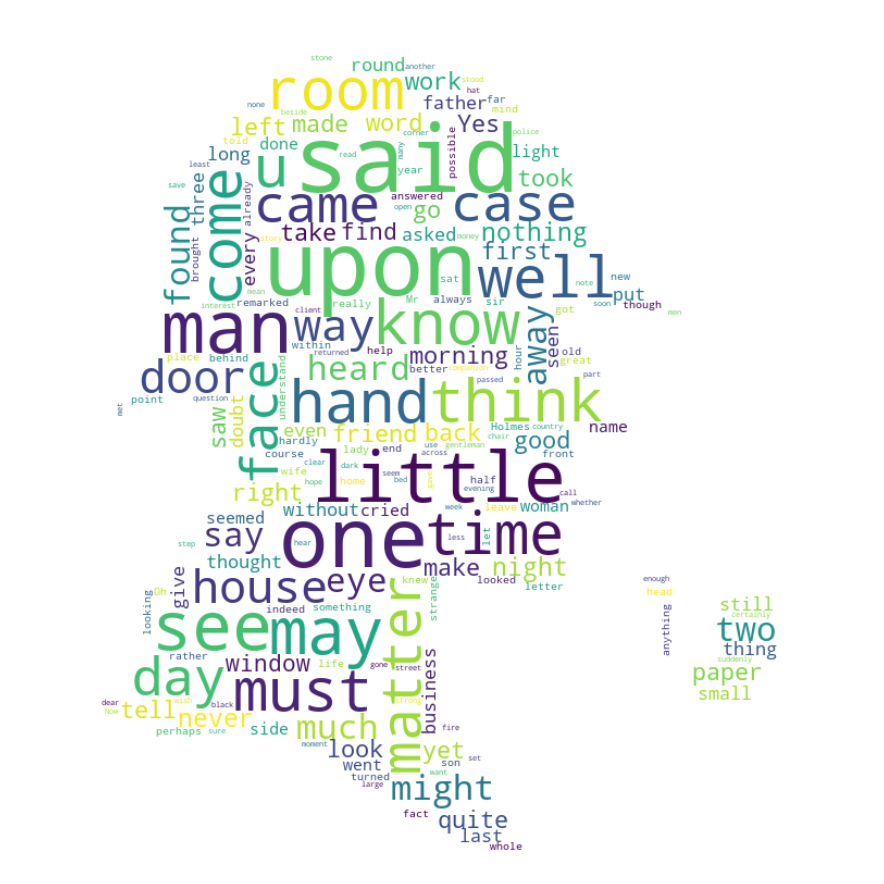

In [20]:
from wordcloud import WordCloud,STOPWORDS
from PIL import Image

text = ' '.join([' '.join(x) for x in processed_sentences])
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
mask = np.array(Image.open('sherlock_image.png'))
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_font_size = 86, relative_scaling=.5, random_state = 42,mask = mask)
wordcloud.generate(text) 
plt.figure(figsize=(24,16))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We can write the WMD optimization model within a function that inputs two documents, and outputs their dissimilairty score.

In [21]:
def score_dissimilarity(D1, D2):

    D1 = set(D1)
    D2 = set(D2) 
    D2 = D2 - set([i for i in D2 if i not in model]) # in case some of the words from the book are not in the word2vec data
    D1 = D1 - set([i for i in D1 if i not in model])
            
    freqency_D1 = {i: list(D1).count(i)/len(D1) for i in D1}
    freqency_D2 = {i: list(D2).count(i)/len(D2) for i in D2}
    
    if len(D2) < 5: # if the sentence is too small, we set a high dissimilarity, effectively ignoring it
        return 1
        
    m = gp.Model("Text_similarity")
    distance = {(i,j): spatial.distance.cosine(model[i],model[j]) for i in D1 for j in D2} 

    # Variables. Adjust the bounds here 
    f = m.addVars(D1,D2,name="f",lb=0,ub=1) 

    # Minimize
    m.ModelSense = GRB.MINIMIZE
    m.setObjective(sum(f[w,w_prime]*distance[w,w_prime] for w in D1 for w_prime in D2))

    # Add the constraints   
    m.addConstrs(f.sum(w, '*') ==  freqency_D1[w] for w in D1)
    m.addConstrs(f.sum('*', w_prime) == freqency_D2[w_prime] for w_prime in D2) 
    
    m.setParam('OutputFlag', 0)
    m.optimize()  
    
    return m.ObjVal

Now, we select a passage that is re-written from the book. The following code has some examples, but feel free to pick any sentence from [the book](https://www.gutenberg.org/cache/epub/1661/pg1661.txt) and create your own plagiarized version.

In [22]:
sample_sentence = 'The small gentleman stood before us, looking back and forth with eyes that expressed both fear and anticipation, as if unsure whether he was about to experience great fortune or a disastrous turn of events.'
# sample_sentence = 'Without much conversation, yet with a friendly gesture, he gestured towards an armchair for me to sit in, offered me a box of cigars, and pointed to a liquor cabinet and a carbonated water dispenser in the corner.' 

print(sample_sentence)

The small gentleman stood before us, looking back and forth with eyes that expressed both fear and anticipation, as if unsure whether he was about to experience great fortune or a disastrous turn of events.


Finally, we iterate over all the sentences in the book, and find the dissimilairty score. The following code only prints the output whenever the dissimilarity goes down in value. The result is a sentence with the smallest dissimilarity.

In [23]:
obj_best = 1
print("#\t Dissimilarity\t Sentence")
for i in range(len(processed_sentences)):  
    obj = score_dissimilarity(pre_processing(sample_sentence),processed_sentences[i])  
    if obj < obj_best: 
        print(i,"\t",round((obj),2),"\t",sentences[i])
        obj_best, sentence_best = obj, sentences[i]

print("\nThe closest sentence with a %f dissimilarity is:\n\n"%obj_best,sentence_best) 

#	 Dissimilarity	 Sentence
1 	 0.81 	 I have seldom heard him mention her under any other name
2 	 0.78 	 In his eyes she eclipses and predominates the whole of her sex
3 	 0.75 	 It was not that he felt any emotion akin to love for Irene Adler
5 	 0.73 	 He was, I take it, the most perfect reasoning and observing machine that the world has seen, but as a lover he would have placed himself in a false position
18 	 0.7 	 As I passed the well-remembered door, which must always be associated in my mind with my wooing, and with the dark incidents of the Study in Scarlet, I was seized with a keen desire to see Holmes again, and to know how he was employing his extraordinary powers
48 	 0.67 	 And yet I believe that my eyes are as good as yours
291 	 0.67 	 On the issue of this question depended whether I should continue my work at Briony Lodge, or turn my attention to the gentleman’s chambers in the Temple
422 	 0.64 	 Irene Adler, as I will still call her, had hurried up the steps; but she

Voila! Did the program correctly identify the passage? Try out other passages and their re-writings!

Copyright © 2023 Gurobi Optimization, LLC